In [57]:
import mysql.connector as mdb
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# Setting up SQL connection
mydb = mdb.connect(
    host="localhost",
    user="root",
    password="root",
    database="online_store"
)
cursor = mydb.cursor()

## Impact of Promotions on Sales

This analysis evaluates whether **promotions** influenced sales performance by comparing:
- Sales volumes of promoted vs. non-promoted items.
- Revenue generated by promotional campaigns.

The results provide insights into the effectiveness of promotions and their contribution to overall sales growth.

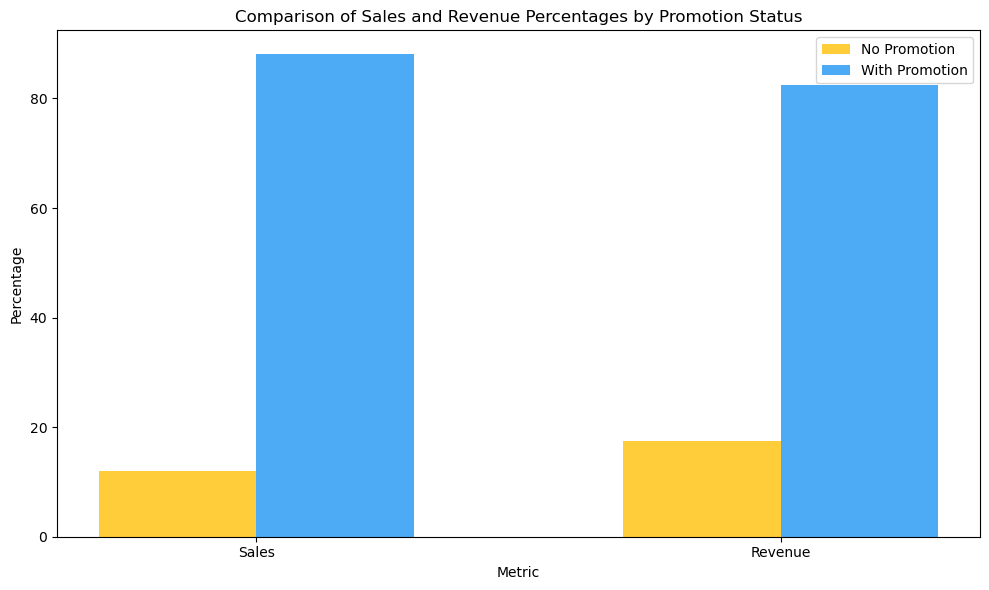

In [58]:
query = """SELECT
   CASE
       WHEN c.is_promoted = 1 THEN 'YES'
       ELSE 'NO'
   END AS is_promoted,
   SUM(cit.amount) AS total_sales_quantity,
   SUM(cit.amount * c.price) AS total_revenue,
   COUNT(DISTINCT c.sku) AS num_products,
   SUM(cit.amount) * 100.0 / (SELECT SUM(l.amount) FROM online_store.clothes_in_transaction l)  AS sales_percentage,
   SUM(cit.amount * c.price) * 100.0 / (SELECT SUM(r.amount * s.price) FROM online_store.clothes s
   JOIN online_store.clothes_in_transaction r ON s.sku = r.sku) AS revenue_percentage
FROM
   online_store.clothes c
JOIN
   online_store.clothes_in_transaction cit ON c.sku = cit.sku
GROUP BY
   c.is_promoted;"""

cursor.execute(query)

result = cursor.fetchall()
columns = [
            "is_promoted",
            "total_sales_quantity",
            "total_revenue",
            "num_products",
            "sales_percentage",
            "revenue_percentage"
        ]
df = pd.DataFrame(result, columns=columns)
# Plotting sales and revenue percentage for comparison
categories = ["Sales", "Revenue"]
values_no = [
    df.loc[df["is_promoted"] == "NO", "sales_percentage"].values[0],
    df.loc[df["is_promoted"] == "NO", "revenue_percentage"].values[0],
]
values_yes = [
    df.loc[df["is_promoted"] == "YES", "sales_percentage"].values[0],
    df.loc[df["is_promoted"] == "YES", "revenue_percentage"].values[0],
]

x = range(len(categories))  # x-axis positions

# Plotting
plt.figure(figsize=(10, 6))
bar_width = 0.3

plt.bar([i - bar_width / 2 for i in x], values_no, bar_width, label="No Promotion", color="#FFC107", alpha=0.8)
plt.bar([i + bar_width / 2 for i in x], values_yes, bar_width, label="With Promotion", color="#2196F3", alpha=0.8)

# Adding labels and details
plt.xticks(x, categories)  # Set x-axis labels as "Sales" and "Revenue"
plt.xlabel("Metric")
plt.ylabel("Percentage")
plt.title("Comparison of Sales and Revenue Percentages by Promotion Status")
plt.legend()

# Show the plot
plt.tight_layout()
plt.show()

## Total Quantity of Items Purchased by Age

This analysis examines the **total quantity of items purchased** segmented by customer age. It provides insights into:
- Purchasing behavior across different age groups.
- Identification of trends and age-based preferences.

The data can help in understanding which age groups contribute the most to purchases and aid in tailoring marketing strategies.

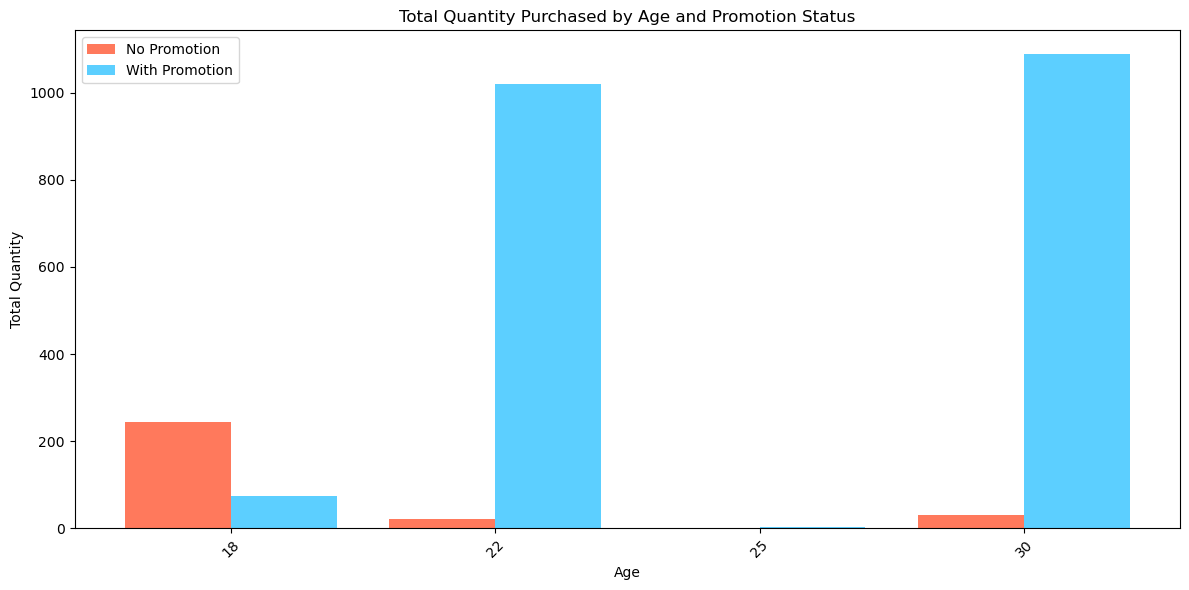

In [ ]:
query = """
        SELECT
    CASE
        WHEN c.is_promoted = 1 THEN 'YES'
        ELSE 'NO'
    END AS is_promoted,
    u.age,
    SUM(cit.amount)
FROM
    online_store.users u
JOIN
    online_store.transactions t ON u.email = t.email
JOIN
    online_store.clothes_in_transaction cit ON t.order_num = cit.order_num
JOIN
    online_store.clothes c ON cit.sku = c.sku
GROUP BY
    u.age,
    is_promoted;
        """
cursor.execute(query)
result = cursor.fetchall()

# Convert result to DataFrame
columns = ["is_promoted", "age", 'total_quantity']
df = pd.DataFrame(result, columns=columns)

pivot_df = df.pivot(index="age", columns="is_promoted", values="total_quantity").fillna(0)

# Plotting
plt.figure(figsize=(12, 6))
x = np.arange(len(pivot_df.index))  # Age groups as x-axis positions
bar_width = 0.4

# Bars for NO and YES
plt.bar(x - bar_width / 2, pivot_df["NO"], bar_width, label="No Promotion", color="#FF5733", alpha=0.8)
plt.bar(x + bar_width / 2, pivot_df["YES"], bar_width, label="With Promotion", color="#33C4FF", alpha=0.8)

# Add labels, title, and legend
plt.xlabel("Age")
plt.ylabel("Total Quantity")
plt.title("Total Quantity Purchased by Age and Promotion Status")
plt.xticks(x, pivot_df.index, rotation=45)  # Add age as x-axis labels
plt.legend()

# Display the plot
plt.tight_layout()
plt.show()

## Analysis of Promoted Items Over Time

This visualization represents the **sales performance of promoted items** over time. Each data point corresponds to a timestamp of purchase, showing:
- Trends in purchase activity for promoted items.
- Identification of peak purchase times.

The graph provides insights into customer behavior and the effectiveness of promotions during specific time periods.

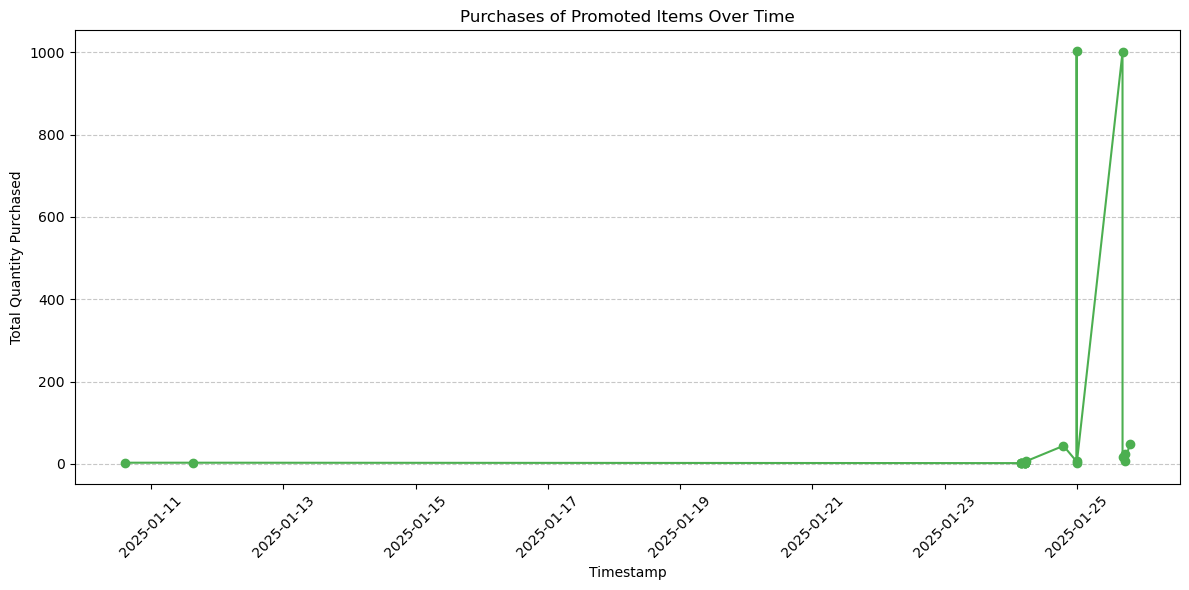

In [80]:
query = """
SELECT
    t.date,
    t.hour,
    SUM(cit.amount) AS total_quantity
FROM
    online_store.transactions t
JOIN
    online_store.clothes_in_transaction cit ON t.order_num = cit.order_num
JOIN
    online_store.clothes c ON cit.sku = c.sku
WHERE
    c.is_promoted = 1 
GROUP BY
    t.hour,
    t.date
ORDER BY
    t.hour,
    t.date;
"""

cursor.execute(query)
result = cursor.fetchall()


columns = ["date", "hour", 'total_quantity']
df = pd.DataFrame(result, columns=columns)

df['hour'] = df['hour'].astype(str)

# Ensure `date` is in datetime format
df['date'] = pd.to_datetime(df['date'])

# Extract only the time part from the `hour` column
df['time'] = df['hour'].str.split(' ').str[-1]

# Combine `date` and `time` into a single `timestamp` column
df['timestamp'] = pd.to_datetime(df['date'].dt.strftime('%Y-%m-%d') + ' ' + df['time'])

df = df.groupby("timestamp", as_index=False)["total_quantity"].sum()
df = df.sort_values("timestamp")

plt.figure(figsize=(12, 6))
plt.plot(df['timestamp'], df['total_quantity'], marker='o', linestyle='-', color="#4CAF50")

# Customize the plot
plt.title("Purchases of Promoted Items Over Time")
plt.xlabel("Timestamp")
plt.ylabel("Total Quantity Purchased")
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()